In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.random_geometric_graph(num_nodes, radius=0.4)
    
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    additional_edges = num_nodes // 2
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.15)
        G[u][v]['load'] = random.uniform(0.05, 1.5)
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0
    
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            return 0

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== Функция для подготовки входных данных =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)

# ===== Обучение =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 25000
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)
        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)
            
            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break
            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== Получение маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None  # зацикливание или недопустимый переход

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Визуализация статистики =====
def visualize_statistics(delivery_times_ospf, delivery_times_nn):
    # Фильтруем только валидные времена доставки (где время > 0)
    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    # Выводим статистику
    mean_ospf = np.mean(valid_ospf)
    sum_ospf = np.sum(valid_ospf)
    mean_nn = np.mean(valid_nn)
    sum_nn = np.sum(valid_nn)

    print(f"OSPF: Среднее время = {mean_ospf:.2f}, Сумма = {sum_ospf:.2f}")
    print(f"Нейросеть: Среднее время = {mean_nn:.2f}, Сумма = {sum_nn:.2f}")

    # Строим гистограмму
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
    plt.title("OSPF: Время доставки пакетов")
    plt.xlabel("Время доставки (в у.е.)")
    plt.ylabel("Количество пакетов")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
    plt.title("Нейросеть:Время доставки пакетов")
    plt.xlabel("Время доставки (в у.е.)")
    plt.ylabel("Количество пакетов")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 0, loss: 1.0465
Epoch 50, loss: 6.2783
Epoch 100, loss: 0.0601
Epoch 150, loss: 0.1185
Epoch 200, loss: 0.0008
Epoch 250, loss: 0.0000
Epoch 300, loss: 0.0001
Epoch 350, loss: 0.0354
Epoch 400, loss: 0.0000
Epoch 450, loss: 0.0000
Epoch 500, loss: 0.0002
Epoch 550, loss: 0.0000
Epoch 600, loss: 0.0175
Epoch 650, loss: 0.0002
Epoch 700, loss: 0.0000
Epoch 750, loss: 0.0038
Epoch 800, loss: 0.0000
Epoch 850, loss: 0.0002
Epoch 900, loss: 0.0000
Epoch 950, loss: 0.0000
Epoch 1000, loss: 0.0650
Epoch 1050, loss: 0.0000
Epoch 1100, loss: 0.0000
Epoch 1150, loss: 0.0000
Epoch 1200, loss: 0.0018
Epoch 1250, loss: 0.0000
Epoch 1300, loss: 0.0000
Epoch 1350, loss: 0.0000
Epoch 1400, loss: 0.0044
Epoch 1450, loss: 0.0000
Epoch 1500, loss: 0.0000
Epoch 1550, loss: 0.0000
Epoch 1600, loss: 0.0000
Epoch 1650, loss: 0.0000
Epoch 1700, loss: 0.0000
Epoch 1750, loss: 0.0000
Epoch 1800, loss: 0.0000
Epoch 1850, loss: 13.4483
Epoch 1900, loss: 0.0000
Epoch 1950, loss: 0.0000
Epoch 2000, loss: 0.00

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2325.08it/s]


OSPF: Среднее время = 10.47, Сумма = 1046.57
Нейросеть: Среднее время = 10.47, Сумма = 1046.57


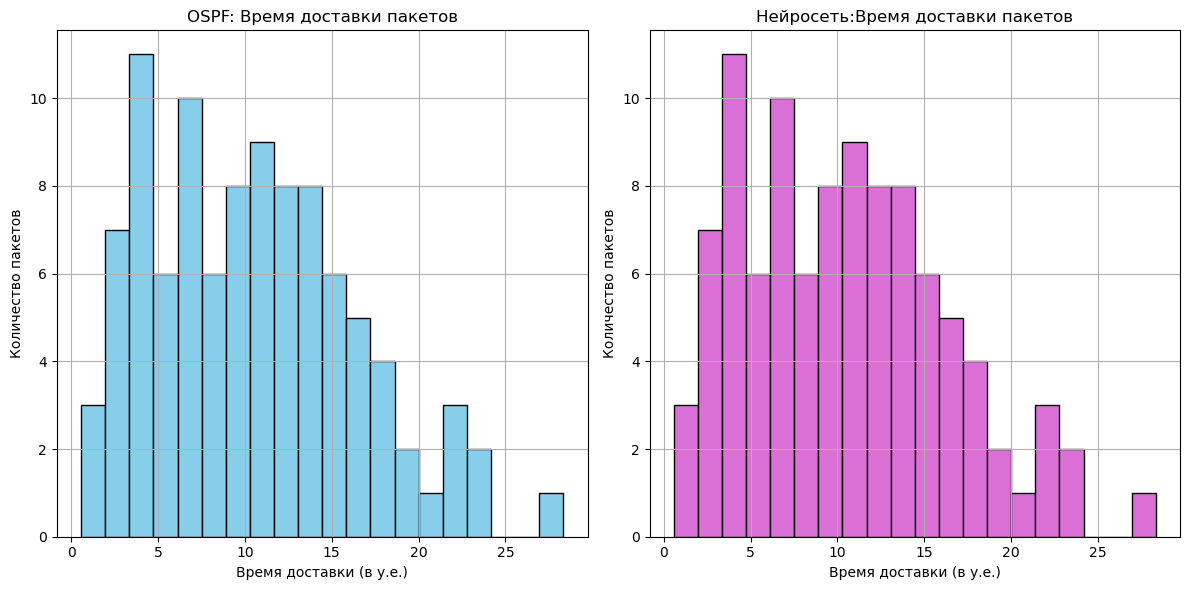

In [8]:
delivery_times_ospf, delivery_times_nn = run_simulation()
visualize_statistics(delivery_times_ospf, delivery_times_nn)



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# ===== Генерация графа =====
def generate_network(num_nodes=40):
    G = nx.random_geometric_graph(num_nodes, radius=0.25)
    
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    additional_edges = num_nodes // 2
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.15)
        G[u][v]['load'] = random.uniform(0.05, 1.5)
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0
    
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            return 0

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        
        # если очередь на узле большая — штраф
        queue_len = len(scheduler.schedule[u])
        overload_penalty = queue_len * 0.2  # каждая запись в расписании — +0.2 у.е.
        
        time += G[u][v]['latency'] + overload_penalty

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time


# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== Функция для подготовки входных данных =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)

# ===== Обучение =====
# ===== Новое обучение: минимизируем время доставки =====
def train_routing_net_rl():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    epochs = 1000
    for epoch in range(epochs):
        net.train()
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)
        max_hops = num_nodes * 2

        log_probs = []
        rewards = []

        while current != dst and len(path) < max_hops:
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)
            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask
            probs = torch.softmax(masked_logits, dim=1)

            dist = torch.distributions.Categorical(probs)
            next_node = dist.sample().item()
            log_probs.append(dist.log_prob(torch.tensor([next_node])))

            if next_node in visited or not G.has_edge(current, next_node):
                break

            current = next_node
            visited.add(current)
            path.append(current)

        if current == dst:
            # получаем награду = -время доставки
            delivery_time = simulate_packet_delivery(G, path, scheduler)
            reward = -delivery_time
            rewards = [reward for _ in log_probs]

            loss = -torch.stack(log_probs).sum() * reward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, reward: {reward:.2f}, path len: {len(path)}")

    return G, net


# ===== Получение маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None  # зацикливание или недопустимый переход

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Визуализация статистики =====
def visualize_statistics(delivery_times_ospf, delivery_times_nn):
    # Фильтруем только валидные времена доставки (где время > 0)
    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    # Выводим статистику
    mean_ospf = np.mean(valid_ospf)
    sum_ospf = np.sum(valid_ospf)
    mean_nn = np.mean(valid_nn)
    sum_nn = np.sum(valid_nn)

    print(f"OSPF: Среднее время = {mean_ospf:.2f}, Сумма = {sum_ospf:.2f}")
    print(f"Нейросеть: Среднее время = {mean_nn:.2f}, Сумма = {sum_nn:.2f}")

    # Строим гистограмму
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
    plt.title("OSPF: Время доставки пакетов")
    plt.xlabel("Время доставки (в у.е.)")
    plt.ylabel("Количество пакетов")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
    plt.title("Нейросеть:Время доставки пакетов")
    plt.xlabel("Время доставки (в у.е.)")
    plt.ylabel("Количество пакетов")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 0, loss: 1.7470
Epoch 50, loss: 0.0074
Epoch 100, loss: 0.2870
Epoch 150, loss: 0.0000
Epoch 200, loss: 0.0018
Epoch 250, loss: 0.0000
Epoch 300, loss: 0.0023
Epoch 350, loss: 0.0000
Epoch 400, loss: 0.0000
Epoch 450, loss: 0.0000
Epoch 500, loss: 0.0321
Epoch 550, loss: 0.0014
Epoch 600, loss: 0.0002
Epoch 650, loss: 0.0000
Epoch 700, loss: 0.0031
Epoch 750, loss: 0.0000
Epoch 800, loss: 0.0088
Epoch 850, loss: 0.0000
Epoch 900, loss: 0.0000
Epoch 950, loss: 0.0000
Epoch 1000, loss: 0.0000
Epoch 1050, loss: 0.0022
Epoch 1100, loss: 0.0000
Epoch 1150, loss: 0.0000
Epoch 1200, loss: 0.0000
Epoch 1250, loss: 0.0021
Epoch 1300, loss: 0.0000
Epoch 1350, loss: 0.0000
Epoch 1400, loss: 0.0000
Epoch 1450, loss: 0.0000
Epoch 1500, loss: 0.0001
Epoch 1550, loss: 0.0000
Epoch 1600, loss: 0.0000
Epoch 1650, loss: 0.0000
Epoch 1700, loss: 0.0000
Epoch 1750, loss: 0.0000
Epoch 1800, loss: 0.0000
Epoch 1850, loss: 0.0000
Epoch 1900, loss: 0.0000
Epoch 1950, loss: 5.4755
Epoch 2000, loss: 0.000

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2127.19it/s]


OSPF: Среднее время = 25.79, Сумма = 2578.71
Нейросеть: Среднее время = 25.79, Сумма = 2578.71


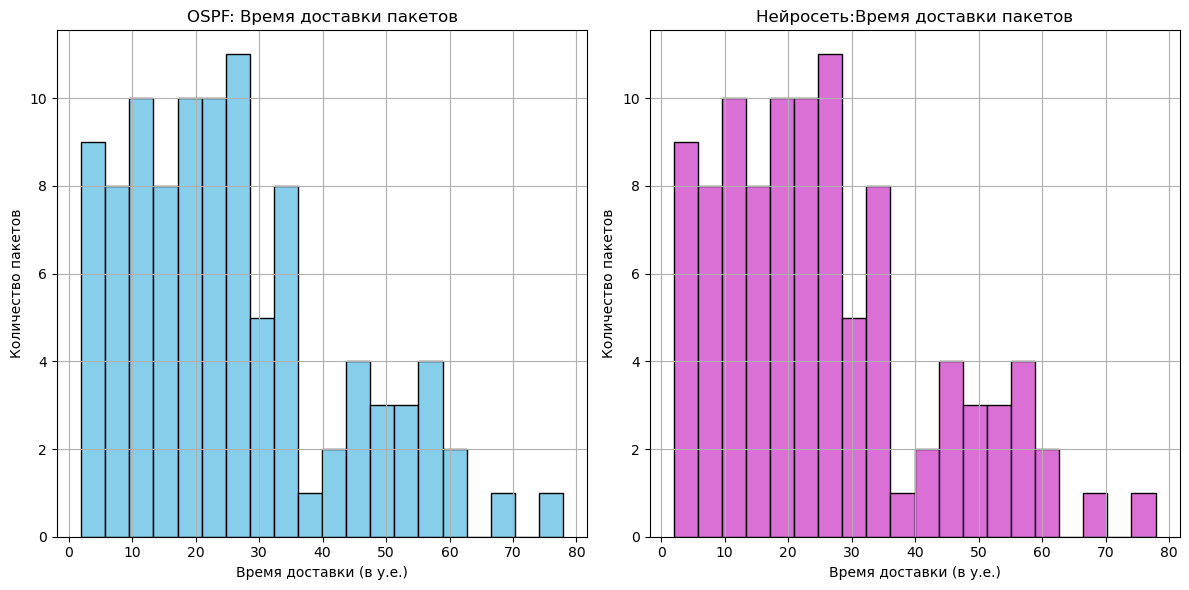

In [12]:
delivery_times_ospf, delivery_times_nn = run_simulation()
visualize_statistics(delivery_times_ospf, delivery_times_nn)

